In [ ]:
%reset
import numpy as np
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
import dill
import sys, os
from astropy.io import fits
import scipy.interpolate as interpolate
sys.path.insert(0, '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/cosmosis_code/')
os.environ['COSMOSIS_SRC_DIR'] = '/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis'
font = {'size': 18}
matplotlib.rc('font', **font)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
import pickle as pk



In [12]:
import math
import numpy as np

the_gold_standard = { 0: (203.0/255.0, 15.0/255.0, 40.0/255.0),
                      1: (255.0/255.0, 165.0/255.0, 0.0),
                      2: (42.0/255.0, 46.0/255.0, 139.0/255.0),
                      3: (0.0/255.0, 153.0/255.0, 204.0/255.0),
                      4: (0.0/255.0, 221.0/255.0, 52.0/255.0),
                      5: (0.0, 0.75, 0.75),
                      6: (0.0, 0.0, 0.0),
                    }

# ******************************************************************************
# definition of color interpolation utilities:

def color_linear_interpolation( rgb_1, rgb_2, alpha ):
    """
    This function performs a linear color interpolation in RGB space.
    alpha has to go from zero to one and is the coordinate.
    """
    _out_color = []
    for _a,_b in zip(rgb_1,rgb_2):
        _out_color.append( float(_a +(_b-_a)*alpha) )
    return tuple(_out_color)


def nice_colors( num, colormap='the_gold_standard', interpolation_method='linear', output_format='RGB' ):
    """
    This function returns a color from a colormap defined above, according to the
    number entered.

    :param num: input number. Can be an integer or float.
        If the number is integer the function returns one of the colors in the
        colormap. If the number is a float returns the shade combining the two
        neighbouring colors.
    :type num: :class:`int` or :class:`float`

    :param colormap: a string containing the name of the colormap.
    :type colormap: :class:`string`

    :param interpolation_method: the method to interpolate between colors.
        Legal choices are:
            interpolation_method='linear', linear interpolation;
        Further interpolation methods will be added in the future.
    :type interpolation_method: :class:`string`

    :param output_format: output format of the color.
        Legal choices are:
            output_format='HEX'
            output_format='RGB' (default)
    :type output_format: :class:`string`

    :return: string with HEX color or tuple with RGB coordinates

    """
    # get the colormap:
    try:
        _cmap = globals()[str(colormap)]
    except:
        raise ValueError('Requested color map ('+str(colormap)+') does not exist.')
    # get the indexes of the color map:
    _idx_low = int( math.floor(num%len(_cmap)) )
    _idx_up  = int( math.floor((_idx_low+1)%len(_cmap)) )
    # perform color interpolation:
    if interpolation_method=='linear':
        _t = num%len(_cmap)-_idx_low
        _out_color = color_linear_interpolation(_cmap[_idx_low],_cmap[_idx_up],_t)
    else:
        raise ValueError('Requested color interpolation method ('+str(interpolation_method)+') does not exist.')
    # choose the output format:
    if output_format=='HEX':
        _out_color = '#%02x%02x%02x' % tuple( [ int(_c*255.) for _c in _out_color] )
        _out_color = str(_out_color)
    elif output_format=='RGB':
        pass
    else:
        raise ValueError('Requested output format ('+str(output_format)+') does not exist.')
    return _out_color


In [31]:
all_halo = fits.open('/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_all_halos.fits')[1].data
zh_all, lmhalo_all = all_halo['z_cgal'], all_halo['lmhalo']
del all_halo




In [32]:
ztype_bin = 'specz'

maglimf = '/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_maglim_data.fits'
magf_all = fits.open(maglimf)[1].data

_, ztrue, lmhalo, uhid, flagc = magf_all['z_dnf_mc_sof'],magf_all['z_cgal'],magf_all['lmhalo'], magf_all['unique_halo_id'], magf_all['flag_central']

del magf_all

M_array = np.logspace(10,16,10)

zmin_array = np.array([0.20, 0.40, 0.55, 0.70, 0.85, 0.95])
zmax_array = np.array([0.40, 0.55, 0.70, 0.85, 0.95, 1.05])

# zall_array = np.linspace(0.2,1.05,40)
# zmin_array = zall_array[:-1]
# zmax_array = zall_array[1:]



nc_pl, ns_pl = np.zeros((len(zmin_array),len(M_array))), np.zeros((len(zmin_array),len(M_array)))
M_mean = np.zeros((len(zmin_array),len(M_array)))
for j in range(len(zmin_array)):
# for j in range(1):
    zminj = zmin_array[j]
    zmaxj = zmax_array[j]


    if ztype_bin == 'photoz':
        ind_sel = np.where((zdnf_all > zminj) & (zdnf_all < zmaxj))[0]

    if ztype_bin == 'specz':
        ind_sel = np.where((ztrue > zminj) & (ztrue < zmaxj))[0]
        
    matj_all = np.array([uhid[ind_sel],lmhalo[ind_sel],flagc[ind_sel]]).T
    print(matj_all.shape)
    matj_all_sort = matj_all[matj_all[:,0].argsort()]
    del matj_all
    uniqueid_j, unique_ind, _, unique_counts = np.unique(matj_all_sort[:,0], return_index=True, return_counts=True, return_inverse=True) 
    Ncj = np.zeros(len(unique_ind))
    Nsj = np.zeros(len(unique_ind))
    Mhaloj = 10**matj_all_sort[unique_ind,1]

    single_ids = np.where(unique_counts == 1)[0]

    fc_unique = matj_all_sort[unique_ind[single_ids],2]
    central_unique_ind = np.where(fc_unique == 0)[0]
    sat_unique_ind = np.where(fc_unique == 1)[0]
    Ncj[single_ids[central_unique_ind]] = 1
    Nsj[single_ids[sat_unique_ind]] = 1

    uc_range = np.unique(unique_counts)[1:]

    for uc in uc_range:
        ind_uc = np.where(unique_counts == uc)[0]
    #     print('doing uc=' + str(uc))
        for ind in ind_uc:
            indc_start = unique_ind[ind]
            indc_stop = unique_ind[ind] + uc
            fc_range = matj_all_sort[indc_start:indc_stop,2]
            fc_cen = np.where(fc_range == 0)[0]
            fc_sat = np.where(fc_range == 1)[0]
            Ncj[ind] = len(fc_cen)
            Nsj[ind] = len(fc_sat)

    all_halo_ind_sel = np.where((zh_all > zminj) & (zh_all < zmaxj))[0]
    lmhalo_all_ind_sel = lmhalo_all[all_halo_ind_sel]
    for jm in range(len(M_array) - 1):
        indj = np.where( (Mhaloj > M_array[jm]) & (Mhaloj < M_array[jm+1]) )[0]
        M_mean[j,jm] = np.mean(Mhaloj[indj])
        ind_all_jm = np.where( (lmhalo_all_ind_sel > np.log10(M_array[jm])) & (lmhalo_all_ind_sel < np.log10(M_array[jm+1])) )[0]

        nc_pl[j,jm] = np.sum(Ncj[indj])/(len(ind_all_jm))
        ns_pl[j,jm] = np.sum(Nsj[indj])/(len(ind_all_jm))

    del all_halo_ind_sel, matj_all_sort



(2912678, 3)


/global/homes/s/spandey/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/global/homes/s/spandey/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars
/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in double_scalars


(1835625, 3)
(2205429, 3)
(2675818, 3)
(1765283, 3)
(1194430, 3)


In [33]:
out_dict = {'M_mean':M_mean,'nc':nc_pl,'ns':ns_pl, 'zmin_array':zmin_array, 'zmax_array':zmax_array}
# savefname = '/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_maglim_hod_measure_zhres.pk'
savefname = '/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_maglim_hod_measure_zfid.pk'
with open(savefname, 'wb') as f:
    dill.dump(out_dict, f)



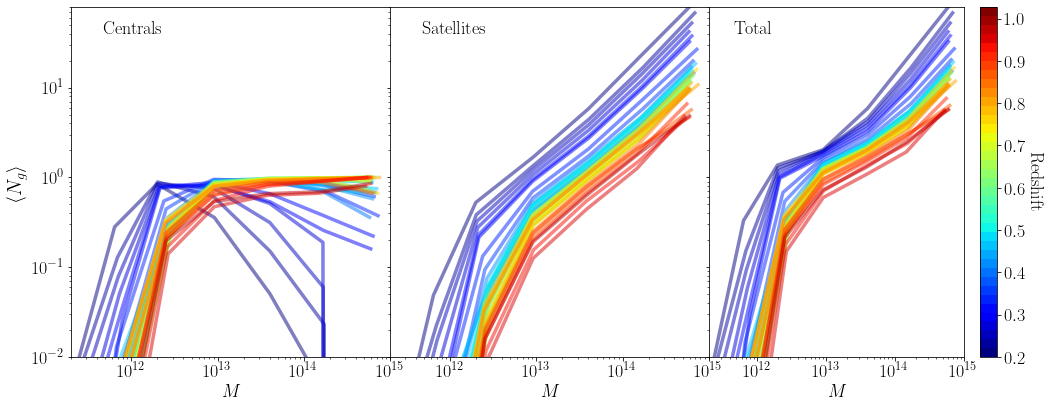

In [5]:

savefname = '/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_maglim_hod_measure_zhres.pk'
out_dict = dill.load(open(savefname,'rb'))

M_mean = out_dict['M_mean']
nc_pl = out_dict['nc']
ns_pl = out_dict['ns']
zmin_array = out_dict['zmin_array']
zmax_array = out_dict['zmax_array']



import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# x = np.linspace(0, 5, 100)
# zmin_cut = zmin_array[np.where(zmin_array>0.61)[0]]
# zmin_cut = zmin_array[np.where(zmin_array<0.6)[0]]
# zmin_cut = zmin_array[np.where( (zmin_array>0.2) & (zmin_array<0.35) )[0]]
zmin_cut = zmin_array
N = len(zmin_cut)
cmap = plt.get_cmap('jet',N)

texts = ['Centrals','Satellites','Total']

fig, ax = plt.subplots(1,3, figsize = (15,6),sharey='row',gridspec_kw = {'wspace':0.0, 'hspace':0.0})
colors = ['red','blue','orange','black','green','magenta']
for j in range(3):
    k = 0
    for jz in range(len(zmin_array)):
        if (zmin_array[jz] > np.amin(zmin_cut)) and (zmin_array[jz] < np.amax(zmin_cut)):
            color =cmap(k)
            if j== 0:
                ax[j].plot(M_mean[jz,:], nc_pl[jz,:],ls='-',marker='',linewidth=3.5,alpha=0.5, color=color, mec=color)  
            if j== 1:
                ax[j].plot(M_mean[jz,:], ns_pl[jz,:],ls='-',marker='',linewidth=3.5,alpha=0.5, color=color, mec=color)  
            if j== 2:
                ax[j].plot(M_mean[jz,:], nc_pl[jz,:] + ns_pl[jz,:],ls='-',marker='',linewidth=3.5,alpha=0.5, color=color, mec=color)    
            k += 1

    ax[j].set_xscale('log')
    ax[j].set_yscale('log')
    ax[j].set_xlabel(r'$M$', size = 18)
#     ax[j].grid(True)
    ax[j].set_ylim(1e-2,8e1)
    ax[j].set_xlim(2e11,1e15)
    ax[j].tick_params(axis='both', which='major', labelsize=18)
    ax[j].tick_params(axis='both', which='minor', labelsize=18)
#     ax[j].legend(fontsize = 18, frameon = False)
    text = texts[j]
    ax[j].text( 0.1, 0.96,text, verticalalignment='top', horizontalalignment='left', transform=ax[j].transAxes, fontsize=18)    


norm = mpl.colors.Normalize(vmin=np.amin(zmin_cut),vmax=np.amax(zmin_cut))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
# plt.colorbar(sm, ticks=np.linspace(0,2,N), 
#              boundaries=np.arange(-0.05,2.1,.1))
cbar = plt.colorbar(sm)
cbar.ax.get_yaxis().labelpad = 18
cbar.ax.set_ylabel('Redshift', rotation=270)

ax[0].set_ylabel(r'$\langle N_g \rangle$', size = 20)
plt.tight_layout()

fig.savefig('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/results/MICE_maglim_hod_evolve_highz_narrowy.pdf')



    
    

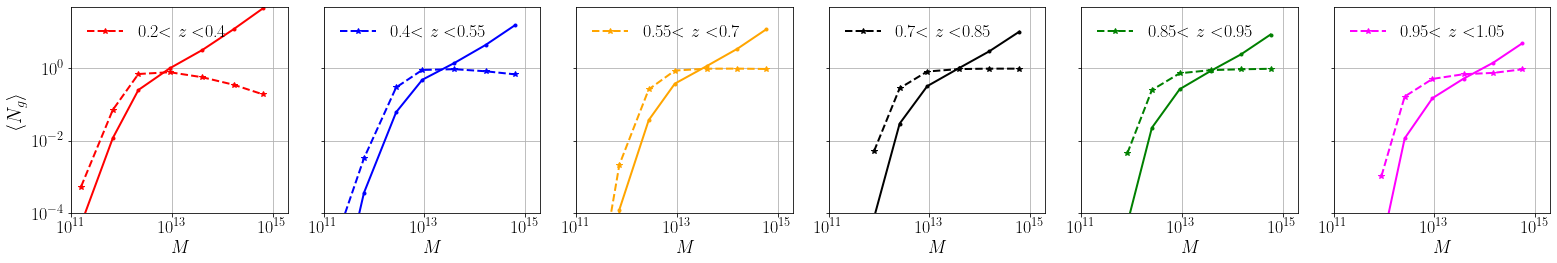

In [10]:
fig, ax = plt.subplots(1,6, figsize = (22,4),sharex=True,sharey='row')
colors = ['red','blue','orange','black','green','magenta']
for j in range(len(zmin_array)):
    ax[j].plot(M_mean[j,:], nc_pl[j,:],ls='--',marker='*',linewidth=2.0,color=colors[j],label= str(zmin_array[j]) + r'$< z <$' + str(zmax_array[j]))  
    ax[j].plot(M_mean[j,:], ns_pl[j,:],ls='-',marker='.',linewidth=2.0,color=colors[j])
    # ax.errorbar(M_block,fv_cl,ls='--',marker='',elinewidth=2.0,color='red',label='Cl')

    ax[j].set_xscale('log')
    ax[j].set_yscale('log')
    ax[j].set_xlabel(r'$M$', size = 18)
    ax[j].grid(True)
    ax[j].set_ylim(1e-4,5e1)
    ax[j].set_xlim(1e11,2e15)
    ax[j].tick_params(axis='both', which='major', labelsize=18)
    ax[j].tick_params(axis='both', which='minor', labelsize=18)
    ax[j].legend(fontsize = 18, frameon = False)
ax[0].set_ylabel(r'$\langle N_g \rangle$', size = 20)
plt.tight_layout()




In [12]:
# out_dict = {'M_mean':M_mean,'nc':nc_pl,'ns':ns_pl, 'zmin_array':zmin_array, 'zmax_array':zmax_array}
# savefname = '/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_maglim_hod_measure.pk'
# with open(savefname, 'wb') as f:
#     dill.dump(out_dict, f)

    


In [142]:
np.linspace(0.15,0.9,50)[1:]


array([0.16530612, 0.18061224, 0.19591837, 0.21122449, 0.22653061,
       0.24183673, 0.25714286, 0.27244898, 0.2877551 , 0.30306122,
       0.31836735, 0.33367347, 0.34897959, 0.36428571, 0.37959184,
       0.39489796, 0.41020408, 0.4255102 , 0.44081633, 0.45612245,
       0.47142857, 0.48673469, 0.50204082, 0.51734694, 0.53265306,
       0.54795918, 0.56326531, 0.57857143, 0.59387755, 0.60918367,
       0.6244898 , 0.63979592, 0.65510204, 0.67040816, 0.68571429,
       0.70102041, 0.71632653, 0.73163265, 0.74693878, 0.7622449 ,
       0.77755102, 0.79285714, 0.80816327, 0.82346939, 0.83877551,
       0.85408163, 0.86938776, 0.88469388, 0.9       ])

In [ ]:
def get_Ncen(M_array, param_array):
    fc, logMmin, sig_lnM = param_array[0], param_array[1], param_array[2]
    

def get_Ptheory_terms(bias_param_array):

    A,b_1,b_2 = bias_param_array[0],bias_param_array[1],bias_param_array[2]
    
    Ptheory_W = (A**2)*(b_1**2)/10. + (A**4)*(b_1*b_2/100. + (b_2**2)/60.)
    Ptheory_G = (A**2)*b_1/10. + (A**4)*(b_2)/2.
    
#     Ptheory_W = (A**2)*(b_1**2)/9. + (A**4)*(b_1*b_2/24. + (b_2**2)/64.)
#     Ptheory_G = (A**2)*b_1/3. + (A**4)*(b_2)/8.

                
    return np.array([Ptheory_W,Ptheory_G])

def get_is_within_prior(bias_param, bias_prior):
    if len(bias_prior) == 2 * len(bias_param):
        is_not_within_prior = 0
        for pj in xrange(len(bias_param)):
            param = bias_param[pj]
            param_prior_min, param_prior_max = bias_prior[2 * pj], bias_prior[2 * pj + 1]
            if (param > param_prior_min) & (param < param_prior_max):
                is_not_within_prior += 0
            else:
                is_not_within_prior += 1

        if is_not_within_prior == 0:
            is_within_prior = True
        else:
            is_within_prior = False

    else:
        print 'Put correct priors on all the parameters of chain'
        sys.exit(1)

    return is_within_prior



def lnprob_func(bias_param, bias_prior, Pk_obs_comp, incov_obs_comp, param_varying_names,param_truth):
    is_within_prior = get_is_within_prior(bias_param, bias_prior)

    if is_within_prior:

        
        if 'A' not in param_varying_names:
            Aval = param_truth['A']
            b1 = bias_param[0]
            b2 = bias_param[1]

        elif 'b2' not in param_varying_names:
            Aval = bias_param[0]
            b1 = bias_param[1]
            b2 = param_truth['b2']
        else:
            Aval = bias_param[0]
            b1 = bias_param[1]
            b2 = bias_param[2]

#         elif 'b1' not in param_varying_names:
#             b1 = param_truth['b1']

#         elif 'b2' not in param_varying_names:
#             b2 = param_truth['b2']





        bias_param_array = np.array([Aval,b1,b2])
        
#         Pk_theory_comp = get_Ptheory_terms(bias_param_array)
#         
        Pk_theory_comp = get_Ptheory_terms_2d(bias_param_array)

        valf = -0.5 * np.dot(np.dot(np.transpose((Pk_obs_comp - Pk_theory_comp)), incov_obs_comp),
                             (Pk_obs_comp - Pk_theory_comp))
    else:
        valf = -np.inf

    # pdb.set_trace()
    return valf



def get_sampler(nwalkers,  bias_prior, Pk_obs_comp, incov_obs_comp, param_varying,param_truth):
    import emcee
    
    ndim = len(param_varying)
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_func,
                                    args=[bias_prior, Pk_obs_comp, incov_obs_comp, param_varying,param_truth])
    return sampler


def get_initial_state(nwalkers, bias_prior,state_type='random'):

    p0_array = []
    for bj in range(0, (len(bias_prior) - 1), 2):
        rand_for_bj = np.random.rand(nwalkers)
        bj_new = bias_prior[bj] + rand_for_bj * (bias_prior[bj + 1] - bias_prior[bj])
        p0_array.append(bj_new)
    p0_array = np.vstack(p0_array)
    p0_final = p0_array.T
#     else:
#         nll = lambda *args: -lnprob_func(*args)
#         ndim = len(bias_prior) / 2
#         parambgbp = np.ones(ndim)

#         # pdb.set_trace()

#         result = op.minimize(nll, parambgbp, args=(
#         bias_prior, Pk_obs_comp, incov_obs_comp, k_obs_comp,wthetalin_gg_interp_array, bins_array), method='Nelder-Mead')
#         theta_hat = result["x"]

#         print theta_hat

#         p0_final = [theta_hat + 1e-6 * np.random.randn(ndim) for i in range(nwalkers)]

    return p0_final



def get_final_pos_mcmc(sampler, p0, nsteps, burn_steps, do_save_chains=True, filename=None, pos_type='median'):
    # sampler.run_mcmc(p0, burn_steps)
    # sampler.reset()
    if filename is not None:
        f = open(filename, "w")
        f.close()

    width = 30
    most_like_pos = []
    most_like = np.infty
    for i, result in enumerate(sampler.sample(p0, iterations=nsteps)):
        n = int((width + 1) * float(i) / nsteps)
        sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
        if do_save_chains:
            position = result[0]
            neglnprob = np.array([-1 * result[1]]).T
            if filename is not None:
                f = open(filename, 'ab')
                # pdb.set_trace()
                savemat = np.concatenate((position, neglnprob), axis=1)
                np.savetxt(f, savemat)
                f.close()
            ml_ind = np.argmin(neglnprob)
            if neglnprob[ml_ind] < most_like:
                most_like = neglnprob[ml_ind]
                most_like_pos = position[ml_ind, :]
                print most_like, most_like_pos

    print most_like, most_like_pos
    sys.stdout.write("\n")

    # sampler.run_mcmc(p0,nsteps)

    # pdb.set_trace()

    para_mcmc_chain = sampler.flatchain
    para_avg_mcmc = (np.sum(para_mcmc_chain, axis=0)) / (len(para_mcmc_chain))
    para_median_mcmc = np.median(para_mcmc_chain, axis=0)

    final_pos_sigma = np.std(para_mcmc_chain, axis=0)

    if pos_type == 'most_like':
        final_pos = most_like_pos
    elif pos_type == 'avg':
        final_pos = para_avg_mcmc
    elif pos_type == 'median':
        final_pos = para_median_mcmc
    else:
        print 'No predefined pos_type given'
        sys.exit(1)

    print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
    print('Mean: ', para_avg_mcmc, ' Median: ', para_median_mcmc, ' Most-Like: ', most_like_pos)

    return final_pos, final_pos_sigma, sampler


def get_chi2fit(para_avg_mcmc, bias_prior, Pk_obs_comp, incov_obs_comp, param_varying,param_truth):
    chi2fit = (-2.) * lnprob_func(para_avg_mcmc, bias_prior, Pk_obs_comp, incov_obs_comp, param_varying,param_truth)
    return chi2fit







In [144]:

# ztype_bin = 'photoz'
ztype_bin = 'specz'
# zmin_array = np.array([ 0.15, 0.35, 0.5, 0.65, 0.8 ])
# zmax_array = np.array([ 0.35, 0.5, 0.65, 0.8, 0.9 ])



M_array = np.logspace(10,16,20)



zall_array = np.linspace(0.15,0.9,50)
zmin_array = zall_array[:-1]
zmax_array = zall_array[1:]

nc_pl, ns_pl = np.zeros((len(zmin_array),len(M_array))), np.zeros((len(zmin_array),len(M_array)))
M_mean = np.zeros((len(zmin_array),len(M_array)))
for j in range(len(zmin_array)):
# for j in range(1):
    zminj = zmin_array[j]
    zmaxj = zmax_array[j]
    
    if zmaxj < 0.65:
        rmf = '/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_redmagic_hdens_wmag.fits'
    else:
        rmf = '/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_redmagic_hlum_wmag.fits'
        
    rm_all = fits.open(rmf)[1].data
    zdnf_all, ztrue, lmhalo, uhid, flagc, ugid = rm_all['zredmagic'],rm_all['z_cgal'],rm_all['lmhalo'], rm_all['unique_halo_id'], rm_all['flag_central'], rm_all['unique_gal_id']      


    if ztype_bin == 'photoz':
        ind_sel = np.where((zdnf_all > zminj) & (zdnf_all < zmaxj))[0]

    if ztype_bin == 'specz':
        ind_sel = np.where((ztrue > zminj) & (ztrue < zmaxj))[0]


    
    matj_all = np.array([uhid[ind_sel],lmhalo[ind_sel],flagc[ind_sel]]).T
    print(matj_all.shape)
    matj_all_sort = matj_all[matj_all[:,0].argsort()]
    uniqueid_j, unique_ind, rev_ind, unique_counts = np.unique(matj_all_sort[:,0], return_index=True, return_counts=True, return_inverse=True) 
    Ncj = np.zeros(len(unique_ind))
    Nsj = np.zeros(len(unique_ind))
    lmhaloj = matj_all_sort[unique_ind,1]

    single_ids = np.where(unique_counts == 1)[0]

    fc_unique = matj_all_sort[unique_ind[single_ids],2]
    central_unique_ind = np.where(fc_unique == 0)[0]
    sat_unique_ind = np.where(fc_unique == 1)[0]
    Ncj[single_ids[central_unique_ind]] = 1
    Nsj[single_ids[sat_unique_ind]] = 1

    uc_range = np.unique(unique_counts)[1:]

    for uc in uc_range:
        ind_uc = np.where(unique_counts == uc)[0]
    #     print('doing uc=' + str(uc))
        for ind in ind_uc:
            indc_start = unique_ind[ind]
            indc_stop = unique_ind[ind] + uc
            fc_range = matj_all_sort[indc_start:indc_stop,2]
            fc_cen = np.where(fc_range == 0)[0]
            fc_sat = np.where(fc_range == 1)[0]
            Ncj[ind] = len(fc_cen)
            Nsj[ind] = len(fc_sat)
    #         import pdb; pdb.set_trace()
    Mhaloj = 10**lmhaloj
    all_halo_ind_sel = np.where((zh_all > zminj) & (zh_all < zmaxj))[0]
    lmhalo_all_ind_sel = lmhalo_all[all_halo_ind_sel]
    for jm in range(len(M_array) - 1):
        indj = np.where( (Mhaloj > M_array[jm]) & (Mhaloj < M_array[jm+1]) )[0]
        M_mean[j,jm] = np.mean(Mhaloj[indj])
        ind_all_jm = np.where( (lmhalo_all_ind_sel > np.log10(M_array[jm])) & (lmhalo_all_ind_sel < np.log10(M_array[jm+1])) )[0]
#         nc_pl[j,jm] = np.mean(Ncj[indj])
#         ns_pl[j,jm] = np.mean(Nsj[indj])

        nc_pl[j,jm] = np.sum(Ncj[indj])/(len(ind_all_jm))
        ns_pl[j,jm] = np.sum(Nsj[indj])/(len(ind_all_jm))





(12889, 3)


/global/homes/s/spandey/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/global/homes/s/spandey/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in double_scalars
/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in double_scalars


(11820, 3)
(18974, 3)
(23082, 3)
(31841, 3)
(31582, 3)
(26748, 3)


/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in double_scalars


(29095, 3)
(33546, 3)
(42977, 3)
(43062, 3)
(48337, 3)
(79015, 3)
(61558, 3)
(55787, 3)
(60652, 3)
(57564, 3)
(58219, 3)
(82807, 3)
(102145, 3)
(103223, 3)
(99084, 3)
(93500, 3)
(91286, 3)
(98578, 3)
(115869, 3)
(129687, 3)
(103328, 3)
(117466, 3)
(117450, 3)
(116211, 3)
(129711, 3)
(13356, 3)
(16854, 3)
(17735, 3)
(17911, 3)
(14484, 3)
(14652, 3)
(14470, 3)
(12434, 3)
(10258, 3)
(12511, 3)
(14313, 3)
(14520, 3)
(15476, 3)
(14860, 3)
(23277, 3)
(15544, 3)
(14945, 3)


In [146]:
# out_dict = {'M_mean':M_mean,'nc':nc_pl,'ns':ns_pl, 'zmin_array':zmin_array, 'zmax_array':zmax_array}
# savefname = '/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_redmagic_hod_measure.pk'
# with open(savefname, 'wb') as f:
#     dill.dump(out_dict, f)

out_dict = {'M_mean':M_mean,'nc':nc_pl,'ns':ns_pl, 'zmin_array':zmin_array, 'zmax_array':zmax_array}
savefname = '/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_redmagic_hod_measure_zhres.pk'
with open(savefname, 'wb') as f:
    dill.dump(out_dict, f)


    



In [11]:
import pickle as pk
df = pk.load(open('/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_redmagic_hod_measure.pk','rb'))
# df.keys()
pk.dump(df, open('/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_redmagic_hod_measure_protocol2.pk','wb'), protocol=2 ) 



In [12]:
import pickle as pk
df = pk.load(open('/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_maglim_hod_measure.pk','rb'))
# df.keys()
pk.dump(df, open('/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_maglim_hod_measure_protocol2.pk','wb'), protocol=2 ) 






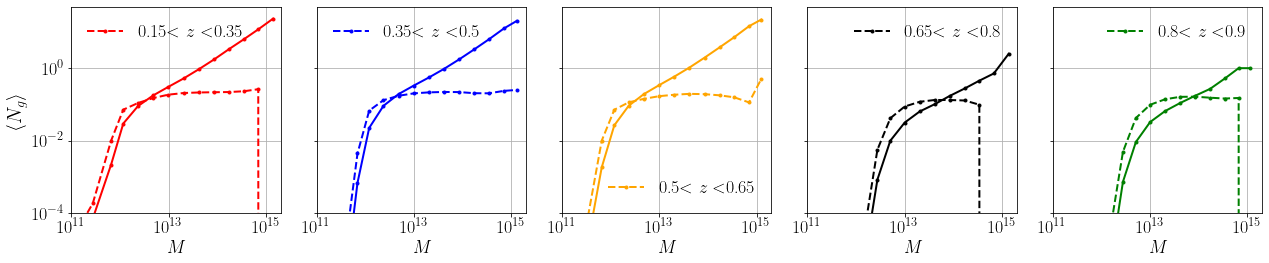

In [14]:
fig, ax = plt.subplots(1,5, figsize = (18,4),sharex=True,sharey='row')
colors = ['red','blue','orange','black','green','magenta']
for j in range(len(zmin_array)):
    ax[j].plot(M_mean[j,:], nc_pl[j,:],ls='--',marker='.',linewidth=2.0,color=colors[j],label= str(zmin_array[j]) + r'$< z <$' + str(zmax_array[j]))  
    ax[j].plot(M_mean[j,:], ns_pl[j,:],ls='-',marker='.',linewidth=2.0,color=colors[j])
    # ax.errorbar(M_block,fv_cl,ls='--',marker='',elinewidth=2.0,color='red',label='Cl')

    ax[j].set_xscale('log')
    ax[j].set_yscale('log')
    ax[j].set_xlabel(r'$M$', size = 18)
    ax[j].grid(True)
    ax[j].set_ylim(1e-4,5e1)
    ax[j].set_xlim(1e11,2e15)
    ax[j].tick_params(axis='both', which='major', labelsize=18)
    ax[j].tick_params(axis='both', which='minor', labelsize=18)
    ax[j].legend(fontsize = 18, frameon = False)
ax[0].set_ylabel(r'$\langle N_g \rangle$', size = 20)
plt.tight_layout()

  


In [179]:
!pip install colormaps


ERROR: Could not find a version that satisfies the requirement colormaps (from versions: none)
ERROR: No matching distribution found for colormaps


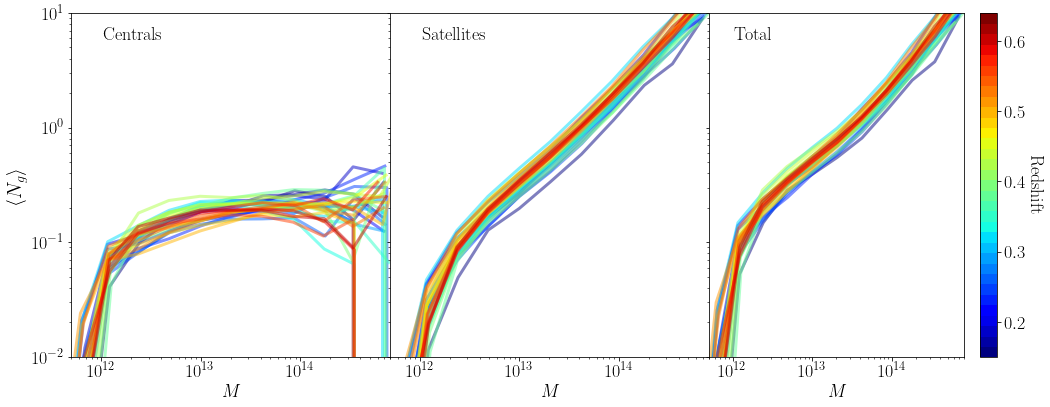

In [12]:
# out_dict = {'M_mean':M_mean,'nc':nc_pl,'ns':ns_pl, 'zmin_array':zmin_array, 'zmax_array':zmax_array}
savefname = '/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_redmagic_hod_measure_zhres.pk'
out_dict = dill.load(open(savefname,'rb'))

M_mean = out_dict['M_mean']
nc_pl = out_dict['nc']
ns_pl = out_dict['ns']
zmin_array = out_dict['zmin_array']
zmax_array = out_dict['zmax_array']

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# x = np.linspace(0, 5, 100)
# zmin_cut = zmin_array[np.where(zmin_array>0.65)[0]]
zmin_cut = zmin_array[np.where(zmin_array<0.65)[0]]
# zmin_cut = zmin_array[np.where( (zmin_array>0.2) & (zmin_array<0.35) )[0]]
N = len(zmin_cut)
cmap = plt.get_cmap('jet',N)

# fig = plt.figure(figsize=(8,6))
# ax1 = fig.add_axes([0.10,0.10,0.70,0.85])

# for i,n in enumerate(np.linspace(0,2,N)):
#     y = np.sin(x)*x**n
#     ax1.plot(x,y,c=cmap(i))

# plt.xlabel('x')
# plt.ylabel('y')



# plt.show()

texts = ['Centrals','Satellites','Total']

fig, ax = plt.subplots(1,3, figsize = (15,6),sharey='row',sharex=True,gridspec_kw = {'wspace':0.0, 'hspace':0.0})
colors = ['red','blue','orange','black','green','magenta']
for j in range(3):
    k = 0
    for jz in range(len(zmin_array)):
        if (zmin_array[jz] > np.amin(zmin_cut)) and (zmin_array[jz] < np.amax(zmin_cut)):
            color =cmap(k)
            if j== 0:
                ax[j].plot(M_mean[jz,:], nc_pl[jz,:],ls='-',marker='',linewidth=3.0,alpha=0.5, color=color, mec=color)  
            if j== 1:
                ax[j].plot(M_mean[jz,:], ns_pl[jz,:],ls='-',marker='',linewidth=3.0,alpha=0.5, color=color, mec=color)  
            if j== 2:
                ax[j].plot(M_mean[jz,:], nc_pl[jz,:] + ns_pl[jz,:],ls='-',marker='',linewidth=3.0,alpha=0.5, color=color, mec=color)    
            k += 1

    ax[j].set_xscale('log')
    ax[j].set_yscale('log')
    ax[j].set_xlabel(r'$M$', size = 18)
#     ax[j].grid(True)
    ax[j].set_ylim(1e-2,1e1)
    ax[j].set_xlim(5e11,8e14)
    ax[j].tick_params(axis='both', which='major', labelsize=18)
    ax[j].tick_params(axis='both', which='minor', labelsize=18)
#     ax[j].legend(fontsize = 18, frameon = False)
    text = texts[j]
    ax[j].text( 0.1, 0.96,text, verticalalignment='top', horizontalalignment='left', transform=ax[j].transAxes, fontsize=18)    


norm = mpl.colors.Normalize(vmin=np.amin(zmin_cut),vmax=np.amax(zmin_cut))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
# plt.colorbar(sm, ticks=np.linspace(0,2,N), 
#              boundaries=np.arange(-0.05,2.1,.1))
cbar = plt.colorbar(sm)
cbar.ax.get_yaxis().labelpad = 18
cbar.ax.set_ylabel('Redshift', rotation=270)

ax[0].set_ylabel(r'$\langle N_g \rangle$', size = 20)
plt.tight_layout()

fig.savefig('/global/cfs/cdirs/des/shivamp/nl_cosmosis/cosmosis/ACTxDESY3/src/results/MICE_wmag_hod_evolve_hdens_narrowy.pdf')


    
    

In [2]:
zmin_maglim = 0.1
zmax_maglim = 1.05

z_min, z_max = np.min(zmin_maglim), np.max(zmax_maglim)
nzbins_total = 35
zarray_all = np.linspace(z_min, z_max, nzbins_total)
zarray_edges = (zarray_all[1:] + zarray_all[:-1]) / 2.
zarray = zarray_all[1:-1]


gal_maglim = fits.open('/global/cfs/cdirs/des/shivamp/actxdes/data_set/mice_sims/micey1_maglim_full.fits')[1].data
ra_g_maglim_all, dec_g_maglim_all, z_g_maglim_all = gal_maglim['RA'],gal_maglim['DEC'],gal_maglim['Z']
ind_maglim = np.where((z_g_maglim_all > zmin_maglim) & (z_g_maglim_all < zmax_maglim))[0]
ra_g_maglim, dec_g_maglim, z_g_maglim = ra_g_maglim_all[ind_maglim], dec_g_maglim_all[ind_maglim], z_g_maglim_all[ind_maglim]
nz_unnorm, z_edge = np.histogram(z_g_maglim_all, zarray_edges)




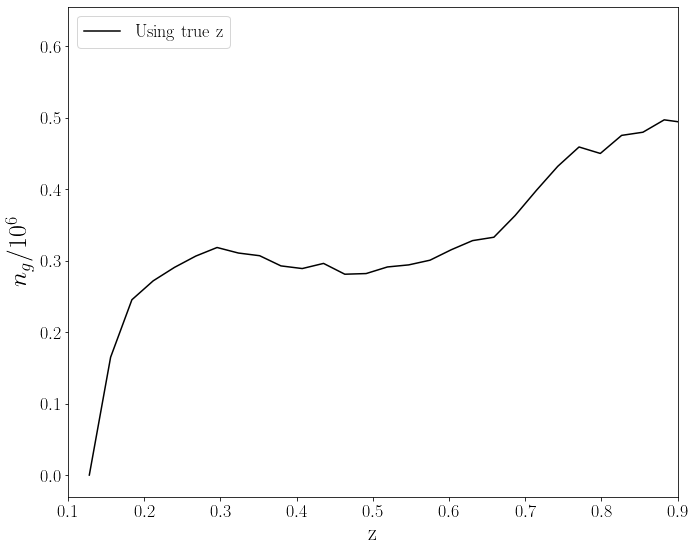

In [4]:
fig, ax = plt.subplots(1,1, figsize = (10,8))
ax.set_xlim(0.1,0.9)
ax.plot(zarray, nz_unnorm/1e6, 'k-', label='Using true z',linewidth=1.5)
# ax.plot(zarray, nz_normed, color='red', label='Original',linewidth=1.8)
ax.legend(fontsize=18, loc='upper left')
plt.xlabel(r'z', fontsize=22)
plt.ylabel(r'$n_g/10^{6}$', fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=18)
plt.tight_layout()



In [39]:
maglimf = '/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_redmagic_hdens_unmag.fits'
fits.open(maglimf)[1].header



XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   52 / length of dimension 1                          
NAXIS2  =              3312050 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   10 / number of table fields                         
TTYPE1  = 'ra      '                                                            
TFORM1  = 'E       '                                                            
TTYPE2  = 'dec     '                                                            
TFORM2  = 'E       '                                                            
TTYPE3  = 'coadd_objects_id'

In [36]:
def get_Nc_Ns(uhid, lmhalo, lmhalo_all_ind_sel, flagc, M_array):
    matj_all = np.array([uhid,lmhalo,flagc]).T
#     print(matj_all.shape)
    matj_all_sort = matj_all[matj_all[:,0].argsort()]
    del matj_all
    uniqueid_j, unique_ind, _, unique_counts = np.unique(matj_all_sort[:,0], return_index=True, return_counts=True, return_inverse=True) 
    Ncj = np.zeros(len(unique_ind))
    Nsj = np.zeros(len(unique_ind))
    Mhaloj = 10**matj_all_sort[unique_ind,1]

    single_ids = np.where(unique_counts == 1)[0]

    fc_unique = matj_all_sort[unique_ind[single_ids],2]
    central_unique_ind = np.where(fc_unique == 0)[0]
    sat_unique_ind = np.where(fc_unique == 1)[0]
    Ncj[single_ids[central_unique_ind]] = 1
    Nsj[single_ids[sat_unique_ind]] = 1

    uc_range = np.unique(unique_counts)[1:]

    for uc in uc_range:
        ind_uc = np.where(unique_counts == uc)[0]
        for ind in ind_uc:
            indc_start = unique_ind[ind]
            indc_stop = unique_ind[ind] + uc
            fc_range = matj_all_sort[indc_start:indc_stop,2]
            fc_cen = np.where(fc_range == 0)[0]
            fc_sat = np.where(fc_range == 1)[0]
            Ncj[ind] = len(fc_cen)
            Nsj[ind] = len(fc_sat)

    nc, ns, Mbar = np.zeros(len(M_array)), np.zeros(len(M_array)), np.zeros(len(M_array))
    for jm in range(len(M_array) - 1):
        indj = np.where( (Mhaloj > M_array[jm]) & (Mhaloj < M_array[jm+1]) )[0]
        Mbar[jm] = np.mean(Mhaloj[indj])
        ind_all_jm = np.where( (lmhalo_all_ind_sel > np.log10(M_array[jm])) & (lmhalo_all_ind_sel < np.log10(M_array[jm+1])) )[0]

        nc[jm] = np.sum(Ncj[indj])/(len(ind_all_jm))
        ns[jm] = np.sum(Nsj[indj])/(len(ind_all_jm))

    return Mbar, nc, ns




In [46]:
import sys, platform, os
sys.path.insert(0,'/global/u1/s/spandey/kmeans_radec/')
from kmeans_radec import KMeans, kmeans_sample
import kmeans_radec

ztype_bin = 'specz'
cat_type = 'redmagic'
do_jk = True
njk = 50
save_dir = '/global/project/projectdirs/des/shivamp/cosmosis/ACTxDESY3/src/results/'
save_filename_jk_obj = 'jkobj_MICE_' + cat_type + '_' + '_njk_' + str(njk) + '.pk'

if cat_type == 'maglim':
    maglimf = '/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_maglim_data.fits'
    magf_all = fits.open(maglimf)[1].data
    del magf_all

    if do_jk:
        ra_all, dec_all, ztrue, lmhalo, uhid, flagc = magf_all['ra_gal'],magf_all['dec_gal'],magf_all['z_cgal'],magf_all['lmhalo'], magf_all['unique_halo_id'], magf_all['flag_central']   
    else:
        ztrue, lmhalo, uhid, flagc = magf_all['z_cgal'],magf_all['lmhalo'], magf_all['unique_halo_id'], magf_all['flag_central']   
    zmin_array = np.array([0.20, 0.40, 0.55, 0.70, 0.85, 0.95])
    zmax_array = np.array([0.40, 0.55, 0.70, 0.85, 0.95, 1.05])
    

if cat_type == 'redmagic':
    zmin_array = np.array([ 0.15, 0.35, 0.5, 0.65, 0.8 ])
    zmax_array = np.array([ 0.35, 0.5, 0.65, 0.8, 0.9 ])    

M_array = np.logspace(10,16,10)


nc_pl, ns_pl = np.zeros((len(zmin_array),len(M_array))), np.zeros((len(zmin_array),len(M_array)))
M_mean = np.zeros((len(zmin_array),len(M_array)))
M_mean_all_jk, nc_all_jk, ns_all_jk = np.zeros((len(zmin_array),len(M_array),njk)), np.zeros((len(zmin_array),len(M_array),njk)), np.zeros((len(zmin_array),len(M_array),njk))  
# for j in range(len(zmin_array)):
for j in range(1):
    zminj = zmin_array[j]
    zmaxj = zmax_array[j]
    
    if j < 3:
        rmf = '/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_redmagic_hdens_wmag.fits'
    else:
        rmf = '/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_redmagic_hlum.fits'
        
#     rm_all = fits.open(rmf)[1].data
#     print(fits.open(rmf)[1].header)
    ra_all, dec_all, zdnf_all, ztrue, lmhalo, uhid, flagc, ugid = rm_all['ra'],rm_all['dec'],rm_all['zredmagic'],\
    rm_all['z_cgal'],rm_all['lmhalo'], rm_all['unique_halo_id'], rm_all['flag_central'], rm_all['unique_gal_id']      

    if ztype_bin == 'photoz':
        ind_sel = np.where((zdnf_all > zminj) & (zdnf_all < zmaxj))[0]

    if ztype_bin == 'specz':
        ind_sel = np.where((ztrue > zminj) & (ztrue < zmaxj))[0]
    all_halo_ind_sel = np.where((zh_all > zminj) & (zh_all < zmaxj))[0]
    
    print('getting JK')
    if do_jk:
        if os.path.isfile(save_dir + save_filename_jk_obj):
            try:
                jkobj_map_radec_centers = pk.load(open(save_dir + save_filename_jk_obj, 'rb'))[
                    'jkobj_map_radec_centers']
            except:
                jkobj_map_radec_centers = pk.load(open(save_dir + save_filename_jk_obj, 'rb'), encoding='latin1')[
                    'jkobj_map_radec_centers']
            jkobj_map = KMeans(jkobj_map_radec_centers)
        else:
            ind_sel_jk = np.where((ztrue > zminj) & (ztrue < zmaxj - 0.1))[0]
            jkobj_map = kmeans_radec.kmeans_sample(np.transpose([ra_all[ind_sel_jk], dec_all[ind_sel_jk]]), njk)
            jk_dict = {'jkobj_map_radec_centers': jkobj_map.centers}
            pk.dump(jk_dict, open(save_dir + save_filename_jk_obj, 'wb'), protocol=2)

        datapoint_jk = jkobj_map.find_nearest(np.transpose([ra_all[ind_sel], dec_all[ind_sel]]))
        
    

    print('getting HOD for the full sample')
    M_mean[j,:], nc_pl[j,:], ns_pl[j,:] = get_Nc_Ns(uhid[ind_sel], lmhalo[ind_sel], lmhalo_all[all_halo_ind_sel], flagc[ind_sel], M_array)
    
    if do_jk:        
        for nj in range(njk):
            print('getting HOD for the jk:' + str(nj))
            ind_big = np.where(datapoint_jk != nj)[0]
            M_mean_all_jk[j,:,nj], nc_all_jk[j,:,nj], ns_all_jk[j,:,nj] = get_Nc_Ns(uhid[ind_sel][ind_big], lmhalo[ind_sel][ind_big], lmhalo_all[all_halo_ind_sel], flagc[ind_sel][ind_big], M_array)      
            


getting JK
getting HOD for the full sample


/global/homes/s/spandey/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/global/homes/s/spandey/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars
/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


getting HOD for the jk:0
getting HOD for the jk:1
getting HOD for the jk:2
getting HOD for the jk:3
getting HOD for the jk:4
getting HOD for the jk:5
getting HOD for the jk:6
getting HOD for the jk:7
getting HOD for the jk:8
getting HOD for the jk:9
getting HOD for the jk:10
getting HOD for the jk:11
getting HOD for the jk:12
getting HOD for the jk:13
getting HOD for the jk:14
getting HOD for the jk:15
getting HOD for the jk:16
getting HOD for the jk:17
getting HOD for the jk:18
getting HOD for the jk:19
getting HOD for the jk:20
getting HOD for the jk:21
getting HOD for the jk:22
getting HOD for the jk:23
getting HOD for the jk:24
getting HOD for the jk:25
getting HOD for the jk:26
getting HOD for the jk:27
getting HOD for the jk:28
getting HOD for the jk:29
getting HOD for the jk:30
getting HOD for the jk:31
getting HOD for the jk:32
getting HOD for the jk:33
getting HOD for the jk:34
getting HOD for the jk:35
getting HOD for the jk:36
getting HOD for the jk:37
getting HOD for the jk

In [47]:
M_mean_bin, nc_pl_bin, ns_pl_bin = M_mean[0,:], nc_pl[0,:], ns_pl[0,:]
M_mean_bin_jk, nc_bin_jk, ns_bin_jk = M_mean_all_jk[0,:,:], nc_all_jk[0,:,:], ns_all_jk[0,:,:]




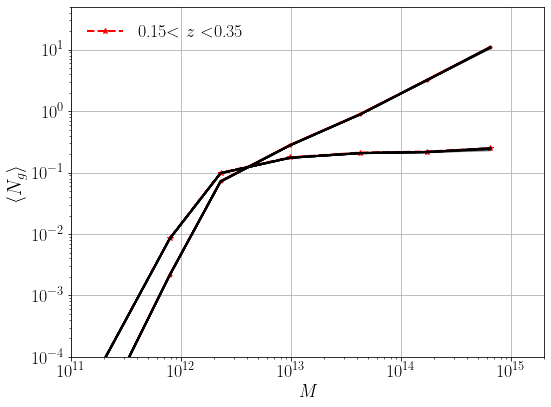

In [48]:
fig, ax = plt.subplots(1,1, figsize = (8,6),sharex=True,sharey='row')
colors = ['red','blue','orange','black','green','magenta']

ax.plot(M_mean_bin, nc_pl_bin,ls='--',marker='*',linewidth=2.0,color=colors[0],label= str(zmin_array[0]) + r'$< z <$' + str(zmax_array[0]))   
ax.plot(M_mean_bin, ns_pl_bin,ls='-',marker='.',linewidth=2.0,color=colors[0])
for nj in range(njk):
    ax.plot(M_mean_bin_jk[:,nj], nc_bin_jk[:,nj],ls='-',marker='',linewidth=2.0,color='k',alpha=0.1)   
    ax.plot(M_mean_bin_jk[:,nj], ns_bin_jk[:,nj],ls='-',marker='',linewidth=2.0,color='k',alpha=0.1)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$M$', size = 18)
ax.grid(True)
ax.set_ylim(1e-4,5e1)
ax.set_xlim(1e11,2e15)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.legend(fontsize = 18, frameon = False)
ax.set_ylabel(r'$\langle N_g \rangle$', size = 20)
plt.tight_layout()







In [49]:
M_mean_bin_jk_mean, nc_bin_jk_mean, ns_bin_jk_mean  = np.tile(np.mean(M_mean_bin_jk,axis=1).reshape(len(M_array),1),(1,njk)), np.tile(np.mean(nc_bin_jk,axis=1).reshape(len(M_array),1),(1,njk)), np.tile(np.mean(ns_bin_jk,axis=1).reshape(len(M_array),1),(1,njk))    
# xi_dytruth_mean = np.tile(np.mean(xi_dytruth_all,axis=0),(njk,1))
M_mean_sigma = np.sqrt((1.0*(njk-1)/njk)*(np.sum(np.square(M_mean_bin_jk - M_mean_bin_jk_mean),axis=1)))

nc_sigma = np.sqrt((1.0*(njk-1)/njk)*(np.sum(np.square(nc_bin_jk - nc_bin_jk_mean),axis=1)))

ns_sigma = np.sqrt((1.0*(njk-1)/njk)*(np.sum(np.square(ns_bin_jk - ns_bin_jk_mean),axis=1)))




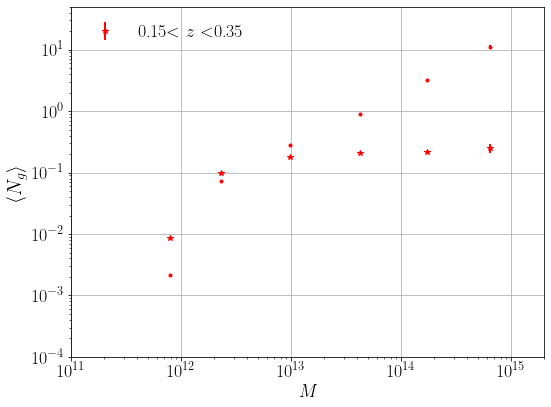

In [50]:
fig, ax = plt.subplots(1,1, figsize = (8,6),sharex=True,sharey='row')
colors = ['red','blue','orange','black','green','magenta']

ax.errorbar(M_mean_bin, nc_pl_bin, nc_sigma,ls='',marker='*',linewidth=2.0,color=colors[0],label= str(zmin_array[0]) + r'$< z <$' + str(zmax_array[0]))   
ax.errorbar(M_mean_bin, ns_pl_bin, ns_sigma,ls='',marker='.',linewidth=2.0,color=colors[0])
# for nj in range(njk):
#     ax.plot(M_mean_bin_jk[:,nj], nc_bin_jk[:,nj],ls='-',marker='',linewidth=2.0,color='k',alpha=0.1)   
#     ax.plot(M_mean_bin_jk[:,nj], ns_bin_jk[:,nj],ls='-',marker='',linewidth=2.0,color='k',alpha=0.1)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$M$', size = 18)
ax.grid(True)
ax.set_ylim(1e-4,5e1)
ax.set_xlim(1e11,2e15)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.legend(fontsize = 18, frameon = False)
ax.set_ylabel(r'$\langle N_g \rangle$', size = 20)
plt.tight_layout()








In [13]:
import dill
savefname = '/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_maglim_hod_measure_zfid.pk'
cat_type = 'maglim'
# savefname = '/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_redmagic_hod_measure_zhres.pk'
# savefname = '/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_redmagic_hod_measure.pk'
# cat_type = 'redmagic'
out_dict = dill.load(open(savefname,'rb'))

if cat_type == 'maglim':
    zmin_array = out_dict['zmin_array']
    zmax_array = out_dict['zmax_array']
#     ind_min = [1,1,2,2,2,2]
#     ind_max = [7,7,7,7,7,7]
    
    

if cat_type == 'redmagic':
    zmin_array = out_dict['zmin_array']
    zmax_array = out_dict['zmax_array']
#     ind_min = [2,4,4,6,6]
#     ind_max = [16,17,17,15,16]





In [14]:
zmin_array


array([0.2 , 0.4 , 0.55, 0.7 , 0.85, 0.95])

In [15]:
from iminuit import Minuit

import scipy.special as ss
def f_cen(logmhalo,logmmin,siglogm,fmaxcen,db=False):
    ncen  = 0.5*( 1. + ss.erf((logmhalo - logmmin)/siglogm) )
    ncen  = fmaxcen * ncen

    return np.log10(ncen)
def f_sat(logmhalo,logmmin,siglogm,fmaxcen,logm1,alpha,db=False): 
    nsat  = 0.5*( 1. + ss.erf((logmhalo - logmmin)/siglogm) )
    nsat  = fmaxcen * nsat  
    nsat  = nsat * (10**logmhalo/10**logm1)**alpha

    return np.log10(nsat)

# def f_cen_yx(logmhalo,logmmin,siglogm,fmaxcen,db=False):
#     ncen  = 0.5*( 1. + ss.erf((logmhalo - logmmin)/siglogm) )
#     ncen  = fmaxcen * ncen

def f_sat_yx(logmhalo,logmmin,siglogm,fmaxcen,logm1,alpha,db=False): 
    nsat  = (10**logmhalo/10**logm1)**alpha
    return np.log10(nsat)
def chi2_all(logmmin,siglogm,fmaxcen,logm1,alpha):
    return np.sum((f_cen(x_cen,logmmin,siglogm,fmaxcen)-y_cen)**2)+np.sum((f_sat(x_sat,logmmin,siglogm,fmaxcen,logm1,alpha)-y_sat)**2)




In [16]:
np.amax(np.array([20]))


20

In [17]:
try1 = np.array([np.nan,0,2,5])
np.where(try1 > 0)[0]


/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


array([2, 3])

/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


[11.1958769  11.82571764 12.33404    12.95644693 13.60483812 14.22580407
 14.8086059 ] [-3.27470283 -1.15361974 -0.16145742 -0.11176068 -0.2513983  -0.45798624
 -0.72490574]
------------------------------------------------------------------
| FCN = 0.3683                  |     Ncalls=238 (238 total)     |
| EDM = 7.57E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
BIN 1
logmmin:12.12961

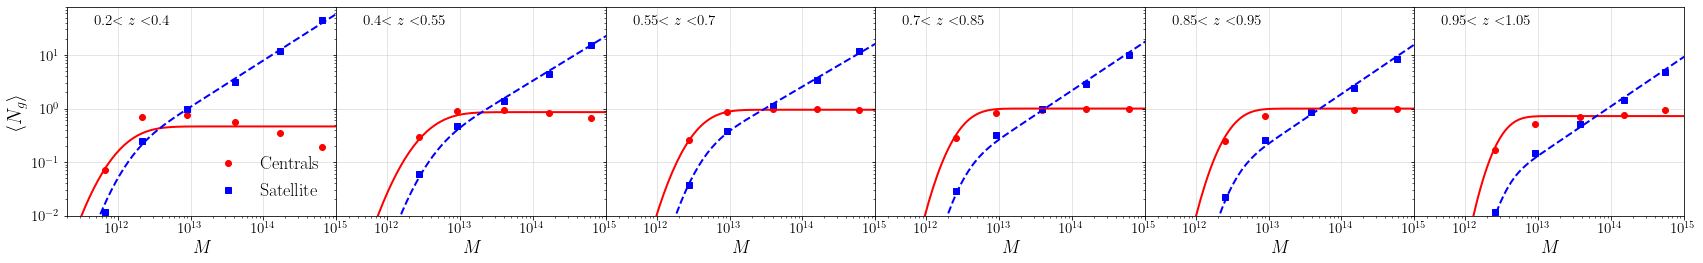

In [18]:
# out_dict['nc'].shape
fig, ax = plt.subplots(1,len(zmin_array), figsize = (4*len(zmin_array),4), gridspec_kw = {'wspace':0.0, 'hspace':0.0},sharey=True,sharex=True)  
colors = ['red','blue','orange','black','green','magenta']

M_array = np.logspace(8,17,300)
zcen_array = 0.5*(np.array(zmin_array) + np.array(zmax_array))
# zcen_array = zmin_array
logfcen_pred_mat = np.zeros((len(zcen_array),len(M_array)))
logfsat_pred_mat = np.zeros((len(zcen_array),len(M_array)))

for j in range(len(zmin_array)):
#     print(out_dict['M_mean'][j,ind_min[j]:ind_max[j]])
#     ind_inf = np.where(np.isinf(out_dict['nc'][j,:]) == 1)[0]
#     if len(ind_inf) > 1:
#         ind_min = ind_inf[0]
#         ind_max = ind_inf[-1]        
    M_cen = (out_dict['M_mean'][j,:])
    n_cen = (out_dict['nc'][j,:])
    M_sat = (out_dict['M_mean'][j,:])
    n_sat = (out_dict['ns'][j,:])
    ind_gtzero = np.where( (M_cen > 0) & (n_cen > 0) & (M_sat > 0) & (n_sat > 0)  )[0]
    M_cen, n_cen, M_sat, n_sat = M_cen[ind_gtzero], n_cen[ind_gtzero], M_sat[ind_gtzero], n_sat[ind_gtzero]
    
#     ind_nan = np.where(np.isnan(n_cen) == 1)[0]
#     print(ind_nan)
#     if len(ind_nan) > 0:
#         print(np.amax(ind_nan),np.amin(ind_nan))
#         if np.amax(ind_nan) > 10:
#             indgt10 = np.where(ind_nan > 10)[0] 
#             ind_max = np.amin(ind_nan[indgt10])
#             print(ind_max)
#         else:
#             ind_max = len(out_dict['nc'][j,:])
        
#         if np.amin(ind_nan) < 10:
#             indlt10 = np.where(ind_nan < 10)[0] 
#             ind_min = np.amax(ind_nan[indlt10])
#         else:
#             ind_min = 0        
#     else:
#         ind_min = 0
#         ind_max = len(out_dict['nc'][j,:])


#     print(ind_min, ind_max)

#     ind_inf = np.where(np.isinf(out_dict['nc'][j,:]) == 1)[0]
#     ind_nan = np.where(np.isnan(out_dict['nc'][j,:]) == 1)[0]

#     print(x_cen)
#     print(out_dict['ns'][j,:])

#     import pdb; pdb.set_trace()
#     x_cen = np.log10(out_dict['M_mean'][j,ind_min:ind_max])
#     y_cen = np.log10(out_dict['nc'][j,ind_min:ind_max])
#     x_sat = np.log10(out_dict['M_mean'][j,ind_min:ind_max])
#     y_sat = np.log10(out_dict['ns'][j,ind_min:ind_max])

    x_cen = np.log10(M_cen)
    y_cen = np.log10(n_cen)
    x_sat = np.log10(M_sat)
    y_sat = np.log10(n_sat)
    print(x_cen, y_cen)
    
    m_all=Minuit(chi2_all,logmmin=11.5,error_logmmin=1,limit_logmmin=(11.,14.),
    siglogm=0.23,error_siglogm=1,limit_siglogm=(0.1,0.5),
    fmaxcen=0.23,error_fmaxcen=1,limit_fmaxcen=(0.1,1.0),
    logm1=13,error_logm1=1,limit_logm1=(12.,14.),
    alpha=1.2,error_alpha=1,limit_alpha=(0.5,2.),
    errordef=1,print_level=1)
    #print results
    m_all.migrad()
    vals = (m_all.values)
    
    print('BIN ' + str(j+1))
    print('logmmin:' + str(vals['logmmin']) + ', siglogm:' + str(vals['siglogm']) + ', fmaxcen:' + str(vals['fmaxcen']))    
    print('logm1:' + str(vals['logm1']) + ', alpha:' + str(vals['alpha']))
    
    fcen_pred_val = (f_cen(np.log10(M_array),vals['logmmin'],vals['siglogm'],vals['fmaxcen'],db=True))
    fsat_pred_val = (f_sat(np.log10(M_array),vals['logmmin'],vals['siglogm'],vals['fmaxcen'],vals['logm1'],vals['alpha'],db=True))   
    fsatyx_pred_val = (f_sat_yx(np.log10(M_array),vals['logmmin'],vals['siglogm'],vals['fmaxcen'],vals['logm1'],vals['alpha']))   
    
    ind_inf = np.where(np.isinf(fsat_pred_val) == 1)[0]
    if len(ind_inf) > 0:
        fcen_pred_val[ind_inf] = -50
        fsat_pred_val[ind_inf] = -40
        fsatyx_pred_val[ind_inf] = -40
    
#     print(fcen_pred_val)
#     print(fsat_pred_val)

    logfcen_pred_mat[j,:] = fcen_pred_val
    logfsat_pred_mat[j,:] = fsatyx_pred_val
    
    ax[j].plot(10**(x_cen), 10**y_cen,ls='',marker='o',linewidth=2.0,color='red',label='Centrals')  
    ax[j].plot(10**(x_sat), 10**y_sat,ls='',marker='s',linewidth=2.0,color='blue',label='Satellite')

    ax[j].plot((M_array), 10**fcen_pred_val,ls='-',marker='',linewidth=2.0,color='red')  
    ax[j].plot((M_array), 10**fsat_pred_val,ls='--',marker='',linewidth=2.0,color='blue')
    ax[j].set_xscale('log')
    ax[j].set_yscale('log')
    ax[j].set_xlabel(r'$M$', size = 18)
    ax[j].grid(True,alpha=0.4)
    
    text = str(zmin_array[j]) + r'$< z <$' + str(zmax_array[j])
    ax[j].text( 0.1, 0.96,text, verticalalignment='top', horizontalalignment='left', transform=ax[j].transAxes, fontsize=15)    
#     ax[j].set_xlim(np.min(M_array),np.max(M_array))
    
    
    if j==0:
        ticks  = np.array([1e11,1e12,1e13,1e14,1e15])
        labels_bottom = [r'$10^{11}$',r'$10^{12}$',r'$10^{13}$',r'$10^{14}$',r'$10^{15}$']
    else:
        ticks  = np.array([1e12,1e13,1e14,1e15])
        labels_bottom = [r'$10^{12}$',r'$10^{13}$',r'$10^{14}$',r'$10^{15}$']


    ax[j].set_xticks(ticks)
    ax[j].set_xticklabels(labels_bottom,  fontsize=15)
    ax[j].set_xlim(2e11,1e15)
    ax[j].set_ylim(1e-2,8e1)
    ax[j].tick_params(axis='both', which='major', labelsize=15)
    ax[j].tick_params(axis='both', which='minor', labelsize=15)
ax[0].legend(fontsize = 18, frameon = False,loc='lower right')
ax[0].set_ylabel(r'$\langle N_g \rangle$', size = 20)
plt.tight_layout()
# fig.savefig('HOD_measure_redmagic.pdf')



fcen_pred_loginterp = interpolate.RectBivariateSpline((zcen_array), np.log(M_array),
                                                                       np.log(10**logfcen_pred_mat))
fsat_pred_loginterp = interpolate.RectBivariateSpline((zcen_array), np.log(M_array),
                                                                       np.log(10**logfsat_pred_mat))

# out_dict = {'z_cen':zcen_array,'M_array':M_array,'fcen_interp':fcen_pred_loginterp, 'fsat_interp':fsat_pred_loginterp}
# savefname = '/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_' + cat_type + '_hod_zM_interp.pk'
# with open(savefname, 'wb') as f:
#     dill.dump(out_dict, f)


    

In [172]:
# out_dict = {'z_cen':zcen_array,'M_array':M_array,'fcen_interp':fcen_pred_loginterp, 'fsat_interp':fsat_pred_loginterp}
# savefname = '/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_' + cat_type + '_hod_zM_interp_zhres.pk'
# with open(savefname, 'wb') as f:
#     dill.dump(out_dict, f)



In [40]:
out_dict = {'z_cen':zcen_array,'M_array':M_array,'fcen_interp':fcen_pred_loginterp, 'fsat_interp':fsat_pred_loginterp}
savefname = '/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_' + cat_type + '_hod_zM_interp_zhres.pk'
with open(savefname, 'wb') as f:
    dill.dump(out_dict, f)




In [171]:
fsat_pred_loginterp(0.43,np.log(1e11))



array([[-88.73473432]])

In [12]:
vals.keys()




['logmmin', 'siglogm', 'fmaxcen', 'logm1', 'alpha']

In [29]:
x_cen = np.log10(out_dict['M_mean'][0,1:7])
y_cen = np.log10(out_dict['nc'][0,1:7])
x_sat = np.log10(out_dict['M_mean'][0,1:7])
y_sat = np.log10(out_dict['ns'][0,1:7])

m_all=Minuit(chi2_all,logmmin=11.5,error_logmmin=1,limit_logmmin=(11.,14.),
siglogm=0.23,error_siglogm=1,limit_siglogm=(0.1,0.5),
fmaxcen=0.23,error_fmaxcen=1,limit_fmaxcen=(0.1,0.5),
logm1=13,error_logm1=1,limit_logm1=(12.,14.),
alpha=1.2,error_alpha=1,limit_alpha=(0.5,2.),
errordef=1,print_level=1)
#print results
m_all.migrad()
vals = (m_all.values)


<ValueView of Minuit at 55555694a810>
  logmmin: 12.14935917707439
  siglogm: 0.4438156037239084
  fmaxcen: 0.4999975695019184
  logm1: 12.603654091477726
  alpha: 0.8322714508634176

No handles with labels found to put in legend.


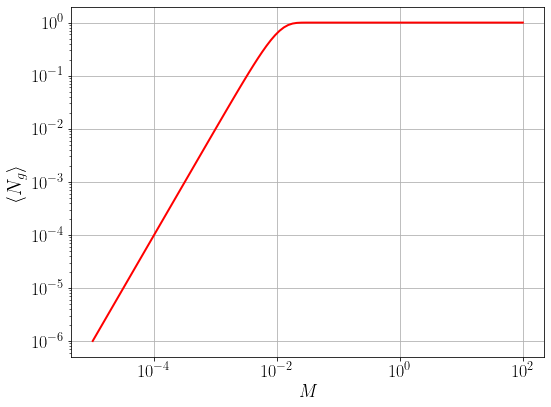

In [15]:
x_arr = np.logspace(-5,2,100)
y_arr = np.ones_like(x_arr)
xstar = 1e-2
y_new = (1. - np.exp(-1.*(x_arr/xstar)**2))*y_arr
fig, ax = plt.subplots(1,1, figsize = (8,6),sharex=True,sharey='row')
colors = ['red','blue','orange','black','green','magenta']
ax.errorbar(x_arr, y_new,ls='-',marker='',linewidth=2.0,color=colors[0])   
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$M$', size = 18)
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.legend(fontsize = 18, frameon = False)
ax.set_ylabel(r'$\langle N_g \rangle$', size = 20)
plt.tight_layout()












In [34]:
maglimf = '/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_maglim_data.fits'
magf_all = fits.open(maglimf)[1].data

ztrue, i_sof, flagc, lmhalo = magf_all['z_cgal'],magf_all['i_sof'], magf_all['flag_central'], magf_all['lmhalo']
ind_b1 = np.where((ztrue > 0.7) & (ztrue < 0.705))[0]

zb, ib, fcb,  lmhb = ztrue[ind_b1], i_sof[ind_b1], flagc[ind_b1], lmhalo[ind_b1]

del magf_all, ztrue, i_sof, flagc, lmhalo





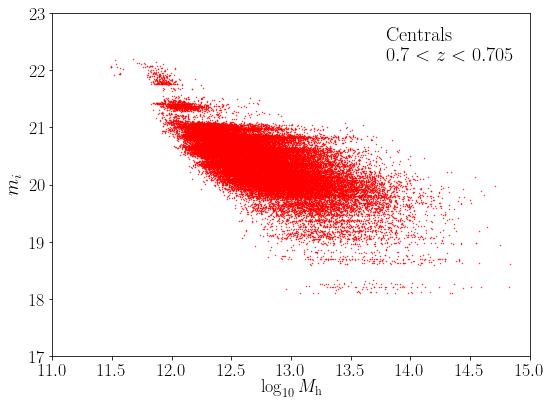

In [35]:
indc = np.where(fcb == 0)[0]
zp, ip = lmhb[indc], ib[indc]
fig, ax = plt.subplots(1,1, figsize = (8,6),sharex=True,sharey='row')
colors = ['red','blue','orange','black','green','magenta']
indr = np.random.randint(0,len(zp),800)
# ax.scatter(zp[indr], ip[indr],s=0.7,marker='.',color=colors[0])   
ax.scatter(zp, ip,s=0.7,marker='.',color=colors[0])   
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(11.0,15.0)
ax.set_ylim(17.0,23.0)
ax.set_xlabel(r'$\log_{10}{M_{\rm h}}$', size = 18)
# ax.grid(True)
text = 'Centrals' + '\n' + r'$0.7 < z < 0.705$'
ax.text( 0.7, 0.96,text, verticalalignment='top', horizontalalignment='left', transform=ax.transAxes, fontsize=20)    
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
# ax.legend(fontsize = 18, frameon = False)
ax.set_ylabel(r'$m_i$', size = 20)
plt.tight_layout()
plt.savefig('mi_logMh_cen_highz.pdf')




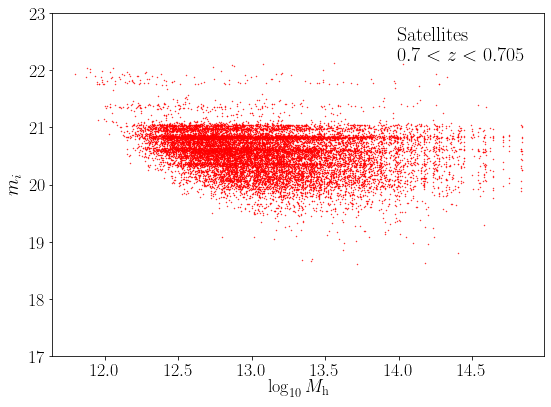

In [36]:
indc = np.where(fcb == 1)[0]
zp, ip = lmhb[indc], ib[indc]
fig, ax = plt.subplots(1,1, figsize = (8,6),sharex=True,sharey='row')
colors = ['red','blue','orange','black','green','magenta']
indr = np.random.randint(0,len(zp),800)
# ax.scatter(zp[indr], ip[indr],s=0.7,marker='.',color=colors[0])   
ax.scatter(zp, ip,s=0.7,marker='.',color=colors[0])   
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_ylim(17.0,23.0)
ax.set_xlabel(r'$\log_{10}{M_{\rm h}}$', size = 18)
# ax.grid(True)
text = 'Satellites' + '\n' + r'$0.7 < z < 0.705$'
ax.text( 0.7, 0.96,text, verticalalignment='top', horizontalalignment='left', transform=ax.transAxes, fontsize=20)    
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
# ax.legend(fontsize = 18, frameon = False)
ax.set_ylabel(r'$m_i$', size = 20)
plt.tight_layout()
plt.savefig('mi_logMh_sat_highz.pdf')




In [3]:
from scipy import integrate
def get_Dcom_array(zarray,Omega_m):
#     Omega_m = self.cosmo.Om0
    Omega_L = 1. - Omega_m
    c = 3 * 10 ** 5
    Dcom_array = np.zeros(len(zarray))
    for j in range(len(zarray)):
        zf = zarray[j]
        res1 = integrate.quad(lambda z: (c / 100) * (1 / (np.sqrt(Omega_L + Omega_m * ((1 + z) ** 3)))), 0, zf)
        Dcom = res1[0]
        Dcom_array[j] = Dcom
    return Dcom_array

def get_Hz(zarray,Omega_m):
#     Omega_m = self.cosmo.Om0
    Omega_L = 1 - Omega_m
    Ez = np.sqrt(Omega_m * (1 + zarray) ** 3 + Omega_L)
    Hz = 100. * Ez
    return Hz

cosmo_params = {'flat': True, 'H0': 70.0, 'Om0': 0.25, 'Ob0': 0.0448, 'sigma8': 0.8, 'ns': 0.95}




In [4]:
# z_array_all = np.linspace(0.2,1.05,20)
# zmin_array = z_array_all[:-1]
# zmax_array = z_array_all[1:]
zmin_array = np.array([0.20, 0.40, 0.55, 0.70, 0.85, 0.95])
zmax_array = np.array([0.40, 0.55, 0.70, 0.85, 0.95, 1.05])
    


# if cat_type == 'redmagic':
#     zmin_array = np.array([ 0.15, 0.35, 0.5, 0.65, 0.8 ])
#     zmax_array = np.array([ 0.35, 0.5, 0.65, 0.8, 0.9 ])   

zcen_array = 0.5*(zmin_array + zmax_array)
maglimf = '/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_maglim_data.fits'
magf_all = fits.open(maglimf)[1].data
ztrue, i_sof, flagc, lmhalo = magf_all['z_cgal'],magf_all['i_sof'], magf_all['flag_central'], magf_all['lmhalo']
lm_mean = np.zeros_like(zmin_array)
lm_std = np.zeros_like(zmin_array)
nbar_mag = np.zeros_like(zmin_array)
sat_frac = np.zeros_like(zmin_array)
for j in range(len(zmin_array)):    
    ind_b1 = np.where((ztrue > zmin_array[j]) & (ztrue < zmax_array[j]))[0]
    zb, ib, fcb,  lmhb = ztrue[ind_b1], i_sof[ind_b1], flagc[ind_b1], lmhalo[ind_b1]
    lm_mean[j] = (np.mean(10**lmhb))
    lm_std[j] = (np.std(10**lmhb))
    
    chi_max = get_Dcom_array([zmax_array[j]],cosmo_params['Om0'])[0]
    chi_min = get_Dcom_array([zmin_array[j]],cosmo_params['Om0'])[0]
    VT = (1./8.)* (4 * np.pi / 3) * (chi_max ** 3 - chi_min ** 3)
    nbar_mag[j] = len(ind_b1)/VT
    sat_frac[j] = len(np.where(fcb == 1)[0])/len(fcb)





In [45]:
# M_array_all = np.logspace(9,15,30)
bin_centers_all = np.log10(np.logspace(10,15,100))
bin_edges = (bin_centers_all[1:] + bin_centers_all[:-1])/2.
bin_centers = bin_centers_all[1:-1]
# bin_edges = np.linspace(bin_min, bin_max + delta_bin, nbins + 1) - delta_bin
delta_bin = bin_centers_all[1] - bin_centers_all[0]



In [46]:
delta_bin


0.050505050505050164

In [47]:
# z_array_all = np.linspace(0.2,1.05,20)
# zmin_array = z_array_all[:-1]
# zmax_array = z_array_all[1:]
zmin_array = np.array([0.20, 0.40, 0.55, 0.70, 0.85, 0.95])
zmax_array = np.array([0.40, 0.55, 0.70, 0.85, 0.95, 1.05])
    


# if cat_type == 'redmagic':
#     zmin_array = np.array([ 0.15, 0.35, 0.5, 0.65, 0.8 ])
#     zmax_array = np.array([ 0.35, 0.5, 0.65, 0.8, 0.9 ])   


zcen_array = 0.5*(zmin_array + zmax_array)
maglimf = '/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_maglim_data.fits'
magf_all = fits.open(maglimf)[1].data
ztrue, i_sof, flagc, lmhalo = magf_all['z_cgal'],magf_all['i_sof'], magf_all['flag_central'], magf_all['lmhalo']
lm_mean = np.zeros_like(zmin_array)
lm_std = np.zeros_like(zmin_array)
nbar_mag = np.zeros_like(zmin_array)
sat_frac = np.zeros_like(zmin_array)
lm_hist = np.zeros((len(zmin_array),len(bin_centers)))
for j in range(len(zmin_array)):    
    ind_b1 = np.where((ztrue > zmin_array[j]) & (ztrue < zmax_array[j]))[0]
    zb, ib, fcb,  lmhb = ztrue[ind_b1], i_sof[ind_b1], flagc[ind_b1], lmhalo[ind_b1]
    lm_mean[j] = (np.mean(10**lmhb))
    lm_std[j] = (np.std(10**lmhb))
    print(np.amin(lmhb))
    
    ghist, _ = np.histogram(lmhb, bins=bin_edges)
    lm_hist[j,:] = ghist / (np.sum(ghist) * delta_bin)
    
    chi_max = get_Dcom_array([zmax_array[j]],cosmo_params['Om0'])[0]
    chi_min = get_Dcom_array([zmin_array[j]],cosmo_params['Om0'])[0]
    VT = (1./8.)* (4 * np.pi / 3) * (chi_max ** 3 - chi_min ** 3)
    nbar_mag[j] = len(ind_b1)/VT
    sat_frac[j] = len(np.where(fcb == 1)[0])/len(fcb)






10.8502
11.1181
11.2803
11.4272
11.5183
11.6081


In [48]:
zmin_array = np.array([ 0.15, 0.35, 0.5, 0.65, 0.8 ])
zmax_array = np.array([ 0.35, 0.5, 0.65, 0.8, 0.9 ])   
zcen_array_rm = 0.5*(zmin_array + zmax_array)
nbar_rm = np.zeros_like(zmin_array)
sat_frac_rm = np.zeros_like(zmin_array)
lm_mean_rm = np.zeros_like(zmin_array)
lm_std_rm = np.zeros_like(zmin_array)
lm_hist_rm = np.zeros((len(zmin_array),len(bin_centers)))
for j in range(len(zmin_array)):  
    if zcen_array[j] < 0.65:
        rmf = fits.open('/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_redmagic_hdens_wmag.fits')[1].data
    else:
        rmf = fits.open('/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_redmagic_hlum_wmag.fits')[1].data
    
    ztrue, lmhalo, flagc = rmf['z_cgal'], rmf['lmhalo'], rmf['flag_central']
    ind_b1 = np.where((ztrue > zmin_array[j]) & (ztrue < zmax_array[j]))[0]
    zb, fcb,  lmhb = ztrue[ind_b1], flagc[ind_b1], lmhalo[ind_b1]
    print(np.amin(lmhb))
    
    ghist, _ = np.histogram(lmhb, bins=bin_edges)
    lm_hist_rm[j,:] = ghist / (np.sum(ghist) * delta_bin)

    lm_mean_rm[j] = (np.mean(10**lmhb))
    lm_std_rm[j] = (np.std(10**lmhb)) 
    
    chi_max = get_Dcom_array([zmax_array[j]],cosmo_params['Om0'])[0]
    chi_min = get_Dcom_array([zmin_array[j]],cosmo_params['Om0'])[0]
    VT = (1./8.)* (4 * np.pi / 3) * (chi_max ** 3 - chi_min ** 3)
    nbar_rm[j] = len(ind_b1)/VT
    sat_frac_rm[j] = len(np.where(fcb == 1)[0])/len(fcb)
        



10.6936
11.3702
11.3889
12.0279
11.983


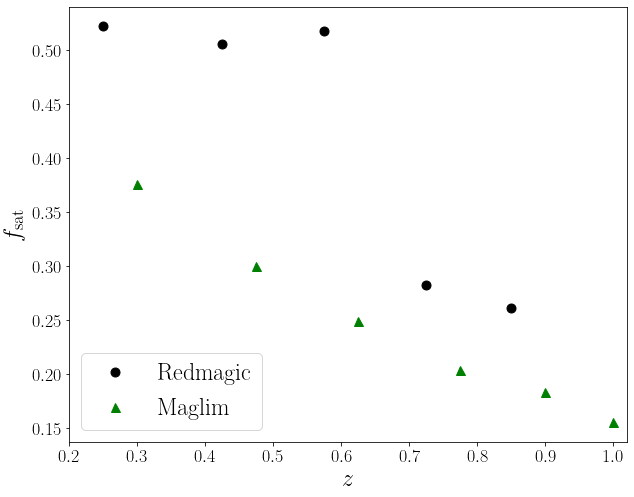

In [49]:
ng = np.array([1.1*1e-3,9.4*1e-5,4e-4])
zg = np.array([0.132,0.342,0.57])

nh = np.array([3.8*1e-4,1.8*1e-5,5.1*1e-5,5.0*1e-5])
zh = np.array([0.0,0.0,0.97,0.97])


fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,8)    

ax.errorbar(zcen_array_rm,sat_frac_rm,ls='',marker='o',color='k',label=r'Redmagic',ms=9.0)
ax.errorbar(zcen_array,sat_frac,ls='',marker='^',color='g',label=r'Maglim',ms=9.0)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(0.2,1.02)
# ax.set_ylim(1e-5,1e-1)
ax.set_ylabel(r'$f_{\rm sat}$',size=24)
ax.set_xlabel(r'$z$',size=24)
ax.legend(fontsize=24,loc='lower left')














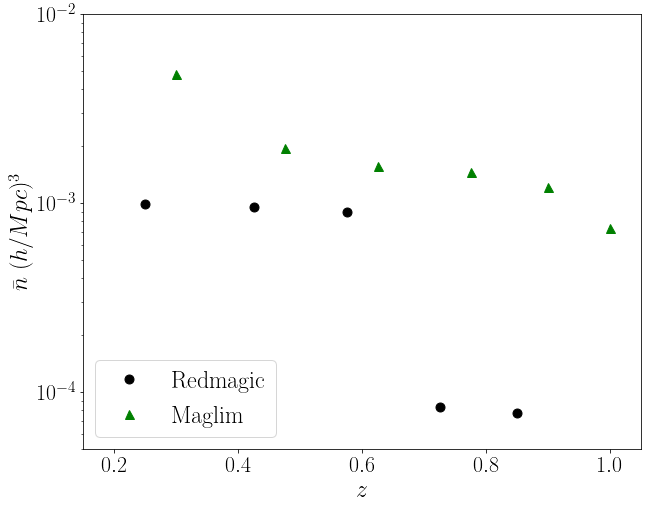

In [22]:
ng = np.array([1.1*1e-3,9.4*1e-5,4e-4])
zg = np.array([0.132,0.342,0.57])

nh = np.array([3.8*1e-4,1.8*1e-5,5.1*1e-5,5.0*1e-5])
zh = np.array([0.0,0.0,0.97,0.97])


fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,8)    
# ax.errorbar(zg,ng,ls='',marker='s',color='r',label=r'E20 galaxies',ms=9.0)
# ax.errorbar(zh,nh,ls='',marker='*',color='b',label=r'E20 halos',ms=9.0)

ax.errorbar(zcen_array_rm,nbar_rm,ls='',marker='o',color='k',label=r'Redmagic',ms=9.0)
ax.errorbar(zcen_array,nbar_mag,ls='',marker='^',color='g',label=r'Maglim',ms=9.0)



# ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlim(-0.05,1.02)
ax.set_xlim(0.15,1.05)
# ax.set_ylim(1e-5,1e-1)
ax.set_ylim(5e-5,1e-2)
ax.tick_params(axis='both', which='major', labelsize=22)
ax.tick_params(axis='both', which='minor', labelsize=22)
ax.set_ylabel(r'$\bar{n}$ $(h/Mpc)^3$',size=24)
ax.set_xlabel(r'$z$',size=24)
ax.legend(fontsize=24,loc='lower left')










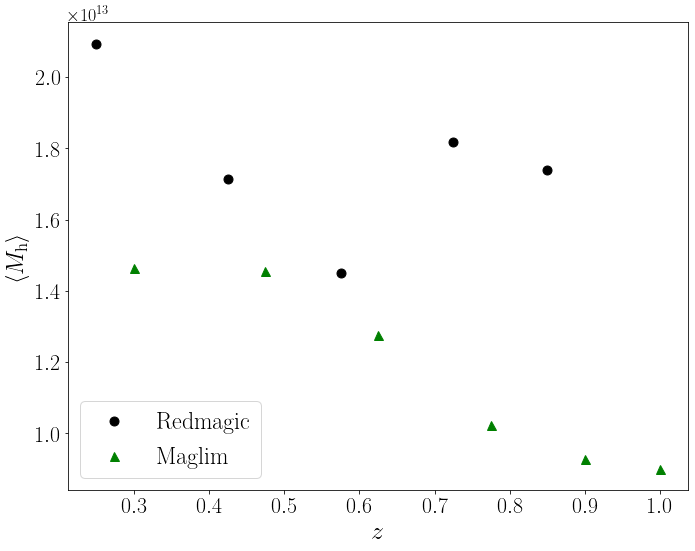

In [21]:
fig, ax = plt.subplots(1,1, figsize = (10,8))
colors = ['red','blue','orange','black','green','magenta']
# ax.errorbar(zcen_array, lm_mean, lm_std,ls='',lw=2.0,marker='s',color=colors[1],label='Maglim')   
# ax.errorbar(1.03*zcen_array, lm_mean_rm,lm_std_rm, ls='',lw=2.0,marker='o',color=colors[0],label='Redmagic')   

ax.errorbar(zcen_array_rm, lm_mean_rm, ls='',marker='o',color='k',label=r'Redmagic',ms=9.0)   
ax.errorbar(zcen_array, lm_mean, ls='',marker='^',color='g',label=r'Maglim',ms=9.0)   

# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim(17.0,23.0)
ax.set_ylabel(r'$\langle {M_{\rm h}} \rangle$', size = 24)
ax.set_xlabel(r'$z$', size = 26)
# ax.grid(True)
# text = 'Satellites' + '\n' + r'$0.7 < z < 0.705$'
# ax.text( 0.7, 0.96,text, verticalalignment='top', horizontalalignment='left', transform=ax.transAxes, fontsize=20)    
ax.tick_params(axis='both', which='major', labelsize=22)
ax.tick_params(axis='both', which='minor', labelsize=22)
ax.legend(fontsize=24,loc='lower left')
# ax.set_ylabel(r'$m_i$', size = 20)
plt.tight_layout()



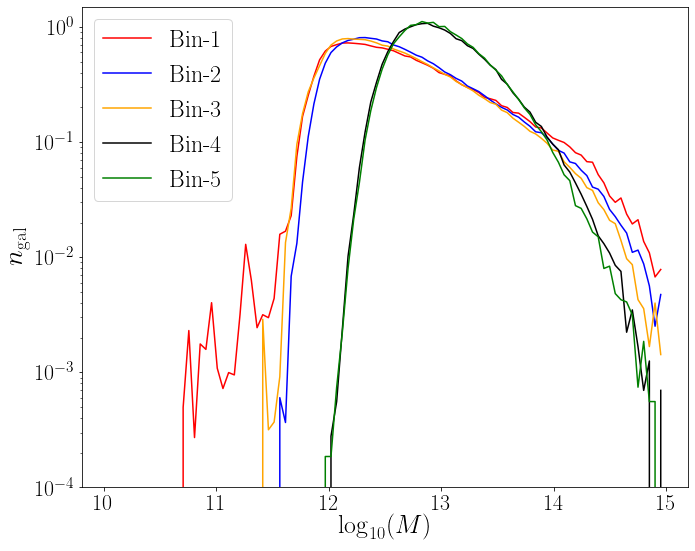

In [54]:
fig, ax = plt.subplots(1,1, figsize = (10,8))
colors = ['red','blue','orange','black','green','magenta']
# ax.errorbar(zcen_array, lm_mean, lm_std,ls='',lw=2.0,marker='s',color=colors[1],label='Maglim')   
# ax.errorbar(1.03*zcen_array, lm_mean_rm,lm_std_rm, ls='',lw=2.0,marker='o',color=colors[0],label='Redmagic')   

for j in range(len(zcen_array_rm)):
    ax.errorbar(bin_centers, lm_hist_rm[j,:], ls='-',marker='',color=colors[j],label='Bin-' + str(j+1),ms=9.0)   
# ax.errorbar(zcen_array, lm_mean, ls='',marker='^',color='g',label=r'Maglim',ms=9.0)   

# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-4,1.5)
ax.set_ylabel(r'$n_{\rm gal}$', size = 27)
ax.set_xlabel(r'$\log_{10}(M)$', size = 26)
# ax.grid(True)
# text = 'Satellites' + '\n' + r'$0.7 < z < 0.705$'
# ax.text( 0.7, 0.96,text, verticalalignment='top', horizontalalignment='left', transform=ax.transAxes, fontsize=20)    
ax.tick_params(axis='both', which='major', labelsize=22)
ax.tick_params(axis='both', which='minor', labelsize=22)
ax.legend(fontsize=24,loc='upper left')
# ax.set_ylabel(r'$m_i$', size = 20)
plt.tight_layout()






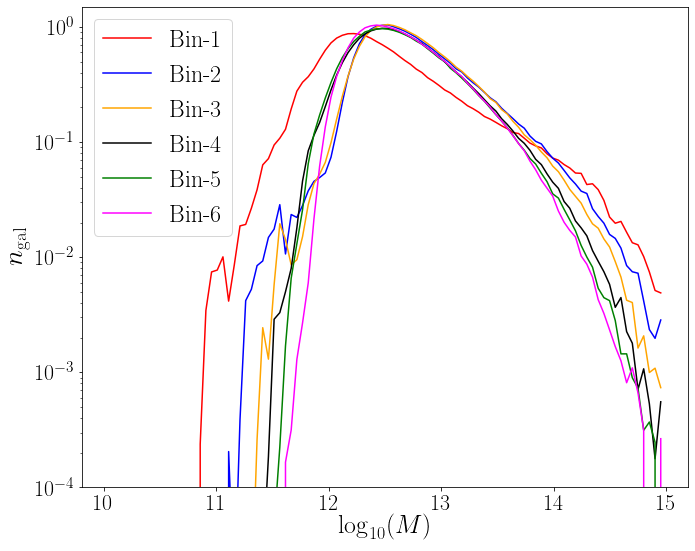

In [55]:
fig, ax = plt.subplots(1,1, figsize = (10,8))
colors = ['red','blue','orange','black','green','magenta']
# ax.errorbar(zcen_array, lm_mean, lm_std,ls='',lw=2.0,marker='s',color=colors[1],label='Maglim')   
# ax.errorbar(1.03*zcen_array, lm_mean_rm,lm_std_rm, ls='',lw=2.0,marker='o',color=colors[0],label='Redmagic')   

for j in range(len(zcen_array)):
    ax.errorbar(bin_centers, lm_hist[j,:], ls='-',marker='',color=colors[j],label='Bin-' + str(j+1),ms=9.0)   
# ax.errorbar(zcen_array, lm_mean, ls='',marker='^',color='g',label=r'Maglim',ms=9.0)   

# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-4,1.5)
ax.set_ylabel(r'$n_{\rm gal}$', size = 27)
ax.set_xlabel(r'$\log_{10}(M)$', size = 26)
# ax.grid(True)
# text = 'Satellites' + '\n' + r'$0.7 < z < 0.705$'
# ax.text( 0.7, 0.96,text, verticalalignment='top', horizontalalignment='left', transform=ax.transAxes, fontsize=20)    
ax.tick_params(axis='both', which='major', labelsize=22)
ax.tick_params(axis='both', which='minor', labelsize=22)
ax.legend(fontsize=24,loc='upper left')
# ax.set_ylabel(r'$m_i$', size = 20)
plt.tight_layout()







In [9]:
zmin_array = np.array([0.20, 0.40, 0.55, 0.70, 0.85, 0.95])
zmax_array = np.array([0.40, 0.55, 0.70, 0.85, 0.95, 1.05])
    
zcen_array = 0.5*(zmin_array + zmax_array)
maglimf = '/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_maglim_data.fits'
magf_all = fits.open(maglimf)[1].data
ztrue, i_sof, flagc, lmhalo = magf_all['z_dnf_mean_sof'],magf_all['i_sof'], magf_all['flag_central'], magf_all['lmhalo']
lm_mean = np.zeros_like(zmin_array)
lm_std = np.zeros_like(zmin_array)
nbar_mag = np.zeros_like(zmin_array)
sat_frac = np.zeros_like(zmin_array)
ntot = np.zeros_like(zmin_array)
for j in range(len(zmin_array)):    
    ind_b1 = np.where((ztrue > zmin_array[j]) & (ztrue < zmax_array[j]))[0]
    print(len(ind_b1))
    ntot[j] = len(ind_b1)
    zb, ib, fcb,  lmhb = ztrue[ind_b1], i_sof[ind_b1], flagc[ind_b1], lmhalo[ind_b1]
    lm_mean[j] = (np.mean(10**lmhb))
    lm_std[j] = (np.std(10**lmhb))
    
    chi_max = get_Dcom_array([zmax_array[j]],cosmo_params['Om0'])[0]
    chi_min = get_Dcom_array([zmin_array[j]],cosmo_params['Om0'])[0]
    VT = (1./8.)* (4 * np.pi / 3) * (chi_max ** 3 - chi_min ** 3)
    nbar_mag[j] = len(ind_b1)/VT
    sat_frac[j] = len(np.where(fcb == 1)[0])/len(fcb)






2934810
2014229
2075512
2667489
1946103
1897385


In [10]:
ntot*(3282.8/5140 )



array([1874395.77198444, 1286441.82124514, 1325581.86645914,
       1703663.98622568, 1242931.30902724, 1211816.24085603])

In [5]:
fits.open('/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/MICE_data/mice_maglim_data.fits')[1].header



XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   88 / length of dimension 1                          
NAXIS2  =             13535536 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   13 / number of table fields                         
TTYPE1  = 'unique_gal_id'                                                       
TFORM1  = 'K       '                                                            
TTYPE2  = 'ra_gal  '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'dec_gal '        